In [48]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 999999

In [49]:
#Reading data
df = pd.read_csv('companies2.csv')

In [50]:
#Removing columns and rows not relevant for this analysis
df = df.drop(['Headquarters Location'], axis=1)
df = df.dropna(subset=['Funding Status'])

In [51]:
#Label encoding the funding status column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['Funding Status'])
df['Funding Status'] = le.transform(df['Funding Status'])

In [52]:
#Further dropping unnecessary columns
nn = df.drop(['Organization Name', 'Categories', 'CB Rank (Company)', 'Top 5 Investors', 'Estimated Revenue Range'], axis=1)

In [53]:
#Applying gender guesser to CEO of each startup
import gender_guesser.detector as gender
d = gender.Detector()
nn['Founder Gender'] = [d.get_gender(x) for x in nn['Founders'].str.split().str.get(0)]
nn['Founder Gender'] = nn['Founder Gender'].replace({'mostly_male':'male', 'mostly_female':'female'})

In [54]:
#Manual encoding of states
early = np.where(np.array(df['Funding Status']) == 0)
late = np.where(np.array(df['Funding Status']) == 2)
seed = np.where(np.array(df['Funding Status']) == 4)
ipo = np.where(np.array(df['Funding Status']) == 1)
ma = np.where(np.array(df['Funding Status']) == 3)

In [55]:
#Cleaning up date format
nn = nn.dropna(subset=['Funding Status'])
nn = nn.dropna(subset=['Founded Date'])
nn['Founded Date'] = nn['Founded Date'].str[:-6]
nn['Closed Date'] = nn['Closed Date'].str[:-6]

In [56]:
#Resetting index
nn = nn.reset_index()
nn = nn.drop(['index'], axis=1)

In [57]:
#Manual encoding of employee size
group1 = np.where(np.array(nn['Number of Employees']) == '10-Jan')
group2 = np.where(np.array(nn['Number of Employees']) == '11-50')
group3 = np.where(np.array(nn['Number of Employees']) == '51-100')
group4 = np.where(np.array(nn['Number of Employees']) == '101-250')
group5 = np.where(np.array(nn['Number of Employees']) == '251-500')
group6 = np.where(np.array(nn['Number of Employees']) == '501-1000')
group7 = np.where(np.array(nn['Number of Employees']) == '1001-5000')
group8 = np.where(np.array(nn['Number of Employees']) == '5001-10000')
group9 = np.where(np.array(nn['Number of Employees']) == '10001+')
for x in group1:
    nn.iloc[x, 4] = 1
for x in group2:
    nn.iloc[x, 4] = 2
for x in group3:
    nn.iloc[x, 4] = 3
for x in group4:
    nn.iloc[x, 4] = 4
for x in group5:
    nn.iloc[x, 4] = 5
for x in group6:
    nn.iloc[x, 4] = 6
for x in group7:
    nn.iloc[x, 4] = 7
for x in group8:
    nn.iloc[x, 4] = 8
for x in group9:
    nn.iloc[x, 4] = 9

In [58]:
#Removing non-numeric characters from columns
cols = ['SimilarWeb - Average Visits (6 months)', 
        'SimilarWeb - Visit Duration', 'SimilarWeb - Monthly Visits Growth']
for x in cols:
    nn[x] = nn[x].str.replace(",", "")
    nn[x] = nn[x].str.replace("%", "")
    nn[x] = pd.to_numeric(nn[x])
    nn = nn.fillna({x:nn[x].mean()})
    
cols2 = ['SimilarWeb - Monthly Visits', 'Apptopia - Downloads Last 30 Days', 
        'Number of Articles', 'IPqwery - Patents Granted', 'IPqwery - Trademarks Registered']
for x in cols2:
    nn[x] = nn[x].str.replace(",", "")
    
    cols3 = ['Number of Employees', 'Number of Founders']
for x in cols3:
    nn[x] = pd.to_numeric(nn[x])
    nn = nn.fillna({x:nn[x].mean()})

In [59]:
#Defining success and failure
#0 is failure, based on entries that have closing dates or entries that have failed to leave
#early stages after 4 years
#2 is success, based on entries that made it to later, more successful stages
#1 is medium, based on entries that are currently alive but not failed, or for entries 
#that do not have enough information for a definitive conclusion of success or failure
nn['Success'] = ""
shape += 1
nn['Founded Date'] = pd.to_numeric(nn['Founded Date'])
nn['Success'] = pd.to_numeric(nn['Success'])
long = np.where(np.array(2019 - nn['Founded Date'] > 4))
for x in long:
    nn.iloc[x, shape] = 0
success1 = np.where(np.array(nn['Funding Status'] == 1))
success2 = np.where(np.array(nn['Funding Status'] == 2))
success3 = np.where(np.array(nn['Funding Status'] == 3))
failed1 = np.array(nn['Closed Date'])
for x in success1:
    nn.iloc[x, shape] = 2
for x in success2:
    nn.iloc[x, shape] = 1   
for x in success3:
    nn.iloc[x, shape] = 2

failed1 = [isinstance(x,str) for x in failed1]
j = np.array([])
i = 0
for x in failed1:
    i += 1
    if x == True:
        j = np.append(j, i)
for x in j:
    nn.iloc[int(x), shape] = 0
nn['Success'] = nn['Success'].fillna(1)

In [60]:
#Manual gender encoding
a1 = np.where(np.array(nn['Founder Gender'] == 'male'))
a2 = np.where(np.array(nn['Founder Gender'] == 'female'))
a3 = np.where(np.array(nn['Founder Gender'] == 'unknown'))
a4 = np.where(np.array(nn['Founder Gender'] == 'andy'))

for x in a1:
    nn.iloc[x, 24] = 0
for x in a2:
    nn.iloc[x, 24] = 1   
for x in a3:
    nn.iloc[x, 24] = 2
for x in a4:
    nn.iloc[x, 24] = 3

shape = nn.shape[1]-1

In [61]:
#Imputing missing data
nn = nn.fillna({'Number of Lead Investors':nn['Number of Lead Investors'].mean(), 
                'Number of Investors':nn['Number of Investors'].mean(),
                'Number of Funding Rounds':nn['Number of Funding Rounds'].mean(),
                'Total Equity Funding Amount Currency (in USD)':nn['Total Equity Funding Amount Currency (in USD)'].mean(),
                'Total Funding Amount Currency (in USD)':nn['Total Funding Amount Currency (in USD)'].mean(),
                'Number of Articles':0,
                'SimilarWeb - Monthly Visits':0,
                'Closed Date':0, 'Apptopia - Number of Apps':0, 'Apptopia - Downloads Last 30 Days':0,
                'IPqwery - Patents Granted':0, 'IPqwery - Trademarks Registered':0, 'Siftery - Total Products Active':1})

nn = nn.drop(['Founders'], axis=1)
shape -= 1

In [62]:
#Train test split with 20% data for testing
x = np.array(nn.iloc[:,:24])
y = np.array(nn.iloc[:,24])
from sklearn import model_selection
x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(x,y,test_size=0.2)

(2096, 5)
(2096,)
(525, 5)
(525,)
Train on 2096 samples, validate on 525 samples
Epoch 1/50
2096/2096 [==============================] - 3s 1ms/step - loss: 0.6412 - acc: 0.6441 - val_loss: 0.6323 - val_acc: 0.6381
Epoch 2/50
2096/2096 [==============================] - 0s 78us/step - loss: 0.6327 - acc: 0.6527 - val_loss: 0.6347 - val_acc: 0.6305
Epoch 3/50
2096/2096 [==============================] - 0s 77us/step - loss: 0.6319 - acc: 0.6675 - val_loss: 0.6329 - val_acc: 0.6343
Epoch 4/50
2096/2096 [==============================] - 0s 77us/step - loss: 0.6274 - acc: 0.6756 - val_loss: 0.6284 - val_acc: 0.6495
Epoch 5/50
2096/2096 [==============================] - 0s 80us/step - loss: 0.6273 - acc: 0.6823 - val_loss: 0.6403 - val_acc: 0.7010
Epoch 6/50
2096/2096 [==============================] - 0s 97us/step - loss: 0.6243 - acc: 0.6918 - val_loss: 0.6175 - val_acc: 0.6438
Epoch 7/50
2096/2096 [==============================] - 0s 116us/step - loss: 0.6216 - acc: 0.6760 - val_loss:

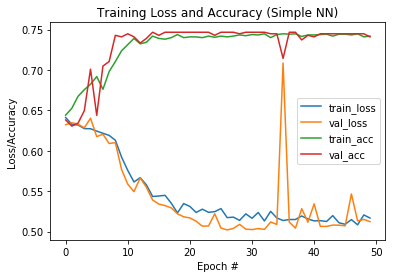

In [47]:
#Creating neural network with 5 dense layers and 3 dropout layers
#Fitting on data, accuracy and loss visualization below
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
model2 = Sequential()
model2.add(Dense(24, activation='sigmoid'))
model2.add(Dropout(0.02))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(12, activation='relu'))
model2.add(Dropout(0.02))
model2.add(Dense(4, activation='relu'))
model2.add(Dropout(0.02))
model2.add(Dense(3, activation='sigmoid'))
from keras.optimizers import SGD
opt = SGD(lr=0.2)
model2.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
from keras.utils import to_categorical
y_binarytrain2 = to_categorical(y_train2)
y_binarytest2 = to_categorical(y_test2)

final2 = model2.fit(x_train2, y_binarytrain2, validation_data=(x_test2, y_binarytest2), epochs=50)

import matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.figure()
plt.plot(N, final2.history["loss"], label="train_loss")
plt.plot(N, final2.history["val_loss"], label="val_loss")
plt.plot(N, final2.history["acc"], label="train_acc")
plt.plot(N, final2.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('Loss and accuracy3')
plt.show()